<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Challenge" data-toc-modified-id="Challenge-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Challenge</a></span></li><li><span><a href="#Preparing-data-and-model-like-before" data-toc-modified-id="Preparing-data-and-model-like-before-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparing data and model like before</a></span></li><li><span><a href="#Validating-the-model" data-toc-modified-id="Validating-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Validating the model</a></span><ul class="toc-item"><li><span><a href="#With-20%-holdout" data-toc-modified-id="With-20%-holdout-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>With 20% holdout</a></span></li><li><span><a href="#Cross-validation-(10-folds)" data-toc-modified-id="Cross-validation-(10-folds)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cross validation (10 folds)</a></span></li></ul></li></ul></div>

# Dataset

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

# Challenge

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

# Preparing data and model like before

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


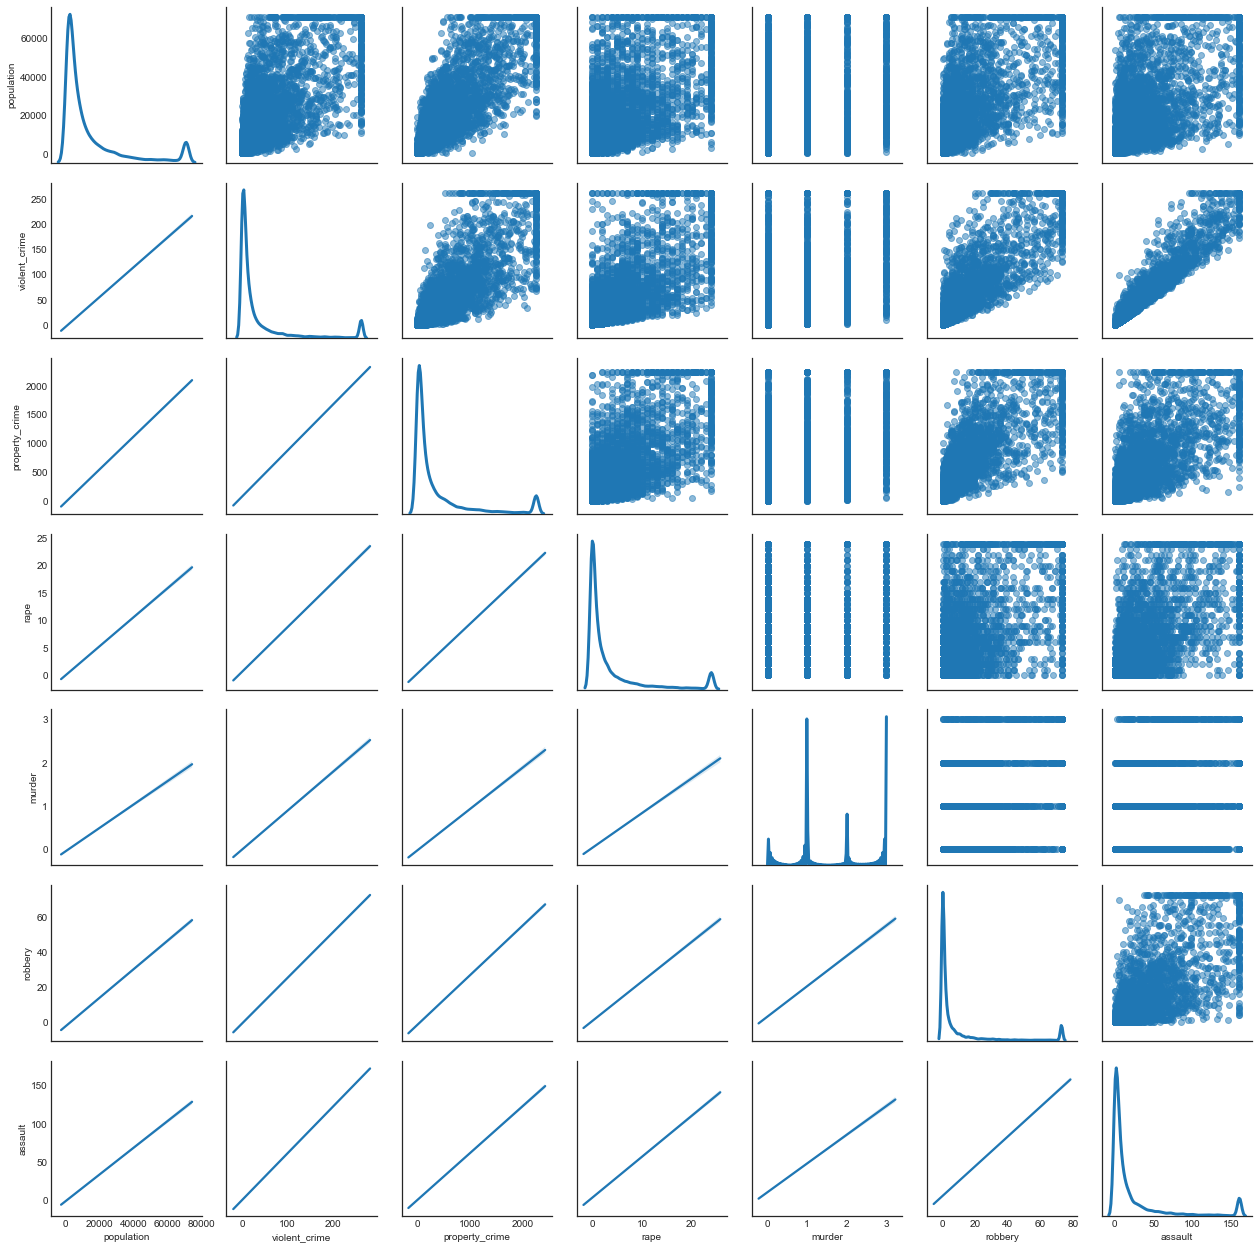

P values:
 Intercept     0.000004
population    0.000000
murder        0.000000
PCA_comp1     0.000015
dtype: float64 

Parameters:
 Intercept     -13.177395
population      0.023974
murder        163.718843
PCA_comp1       5.202101
dtype: float64 

R squared:
 0.8513214194176398 

Confidence Interval:
                      0           1
Intercept   -18.781057   -7.573732
population    0.023662    0.024286
murder      156.410035  171.027651
PCA_comp1     2.850956    7.553246 



In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
%matplotlib inline

sns.set_style('white')

#Load data
df1 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_State_by_City_2013.xls',
                   header=3, usecols = 'C:M')
df2 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls',
                   header=4, usecols = 'B:L')
df = df1.append(df2)
df['Rape\n(revised\ndefinition)1'] = df['Rape\n(revised\ndefinition)1'].fillna(0)
df['Rape\n(legacy\ndefinition)2'] = df['Rape\n(legacy\ndefinition)2'].fillna(0)
df['rape'] = df['Rape\n(revised\ndefinition)1'] + df['Rape\n(legacy\ndefinition)2']

#Make subtable
df_sub = df[['Population', 'Violent\ncrime', 'Property\ncrime', 'rape', 
         'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Aggravated\nassault']].copy()
df_sub.columns = ['population', 'violent_crime', 'property_crime', 'rape',
               'murder', 'robbery', 'assault']

#Check how many null values we have for each column
df_sub.isnull().sum()

#Drop missing values.
df_sub = df_sub.dropna()

#Apply winsorizing to eliminate outliers
def using_mstats(s):
    return stats.mstats.winsorize(s, limits=[0.05, 0.05])
df_win = df_sub.apply(using_mstats, axis=0)

#Check distribution
g = sns.PairGrid(df_win, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

#Make a table just for the features
df_x = df_win.drop(columns='property_crime').copy()
corrmax = df_x.corr()

#It looks like violent crimes, rape, robbery and assult are highly correlated
pca_list = ['violent_crime', 'rape', 'robbery', 'assault']

df_pca = df_x.loc[:, pca_list]
X = preprocessing.StandardScaler().fit_transform(df_pca)

pca = PCA(n_components=4)
Y_sklearn = pca.fit_transform(X)

df_x['PCA_comp1'] = pd.DataFrame(Y_sklearn)[0]
df_x = df_x.drop(columns = pca_list)

#use smf
df_smf = df_x.copy()
df_smf['property_crime'] = df_win['property_crime']
est = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=df_smf).fit()
print('P values:\n', est.pvalues, '\n')
print('Parameters:\n', est.params, '\n')
print('R squared:\n', est.rsquared, '\n')
print('Confidence Interval:\n', est.conf_int(), '\n')

# Validating the model

## With 20% holdout


In [3]:
#With 20% holdout
X_train, X_test, y_train, y_test = train_test_split(
        df_smf[['population', 'murder', 'PCA_comp1']],
        df_smf['property_crime'], test_size=0.2, random_state=20
        )
lm_train = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=pd.concat([X_train, y_train], axis=1)).fit()
print('P values of the training set:\n', lm_train.pvalues, '\n')
print('R squared of the training set:\n', lm_train.rsquared, '\n')

lm_test = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=pd.concat([X_test, y_test], axis=1)).fit()
lm_test.rsquared
print('P values of the test set:\n', lm_test.pvalues, '\n')
print('R squared of the test set:\n', lm_test.rsquared, '\n')


P values of the training set:
 Intercept      5.165116e-04
population     0.000000e+00
murder        3.772306e-308
PCA_comp1      2.153339e-04
dtype: float64 

R squared of the training set:
 0.8465001390406748 

P values of the test set:
 Intercept     5.819862e-04
population    0.000000e+00
murder        2.666093e-78
PCA_comp1     2.122001e-02
dtype: float64 

R squared of the test set:
 0.8707728646245927 



## Cross validation (10 folds)

In [4]:
#Cross validation
X1 = df_smf[['population', 'murder', 'PCA_comp1']]
y1 = df_smf['property_crime']

kf = KFold(n_splits=10)
a = kf.get_n_splits(X1)

for k, (train, test) in enumerate(kf.split(X1, y1)):
    lm_cv_train = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=pd.concat([X1.loc[train], y1.loc[train]], axis=1)).fit()
    lm_cv_test = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=pd.concat([X1.loc[test], y1.loc[test]], axis=1)).fit()
    print('Fold {} train r2: {}, test r2: {}'.format(
            k, lm_cv_train.rsquared, lm_cv_test.rsquared))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


Fold 0 train r2: 0.8404840881826928, test r2: 0.8736307423638968
Fold 1 train r2: 0.8506009173150177, test r2: 0.8531680442848633


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Fold 2 train r2: 0.8520914630727365, test r2: 0.8416486458680136
Fold 3 train r2: 0.8533710324380073, test r2: 0.8363500524357186
Fold 4 train r2: 0.8506865054729777, test r2: 0.8532288506378121
Fold 5 train r2: 0.8603007654937201, test r2: 0.767332732780238
Fold 6 train r2: 0.8516828181098963, test r2: 0.8568363590248522
Fold 7 train r2: 0.8543904998081745, test r2: 0.7890127765134165
Fold 8 train r2: 0.8459316426786545, test r2: 0.8980954069720901
Fold 9 train r2: 0.8512129788297662, test r2: 0.8679943338633314
